### Необходимык библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20, 12)})

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Colab Notebooks/Диплом
%ls

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Диплом
texts_emb.ipynb  комментарии_банки.xlsx


### Подготавливаем данные

In [ ]:
comments_raw_data = pd.read_excel('Новости коммераснат.xlsx')

comments_raw_data['datetime'] = pd.to_datetime(comments_raw_data['datetime'], format='%d.%m.%Y, %H:%M')
comments_raw_data = comments_raw_data.drop(columns=['Unnamed: 0'])

### Cтатистики

In [ ]:
min_ = comments_raw_data["datetime"].min().date()
max_ = comments_raw_data["datetime"].max().date()
print(f'min: {min_} \nmax: {max_}')

min: 2020-11-09 
max: 2023-11-06


In [ ]:
bank_counts = np.unique(comments_raw_data['bank'], return_counts=True)
popularity = sorted(list(zip(bank_counts[0], bank_counts[1])), key=lambda x:x[1], reverse=True)

In [ ]:
top_pop = 40
bank_set_ = popularity[:top_pop] #возьмем первык 40 банков
bank_set = [x[0] for x in bank_set_]

Text(0.5, 1.0, 'Кол-во статей с упоминаний c 2020-11-09 по 2023-11-06')

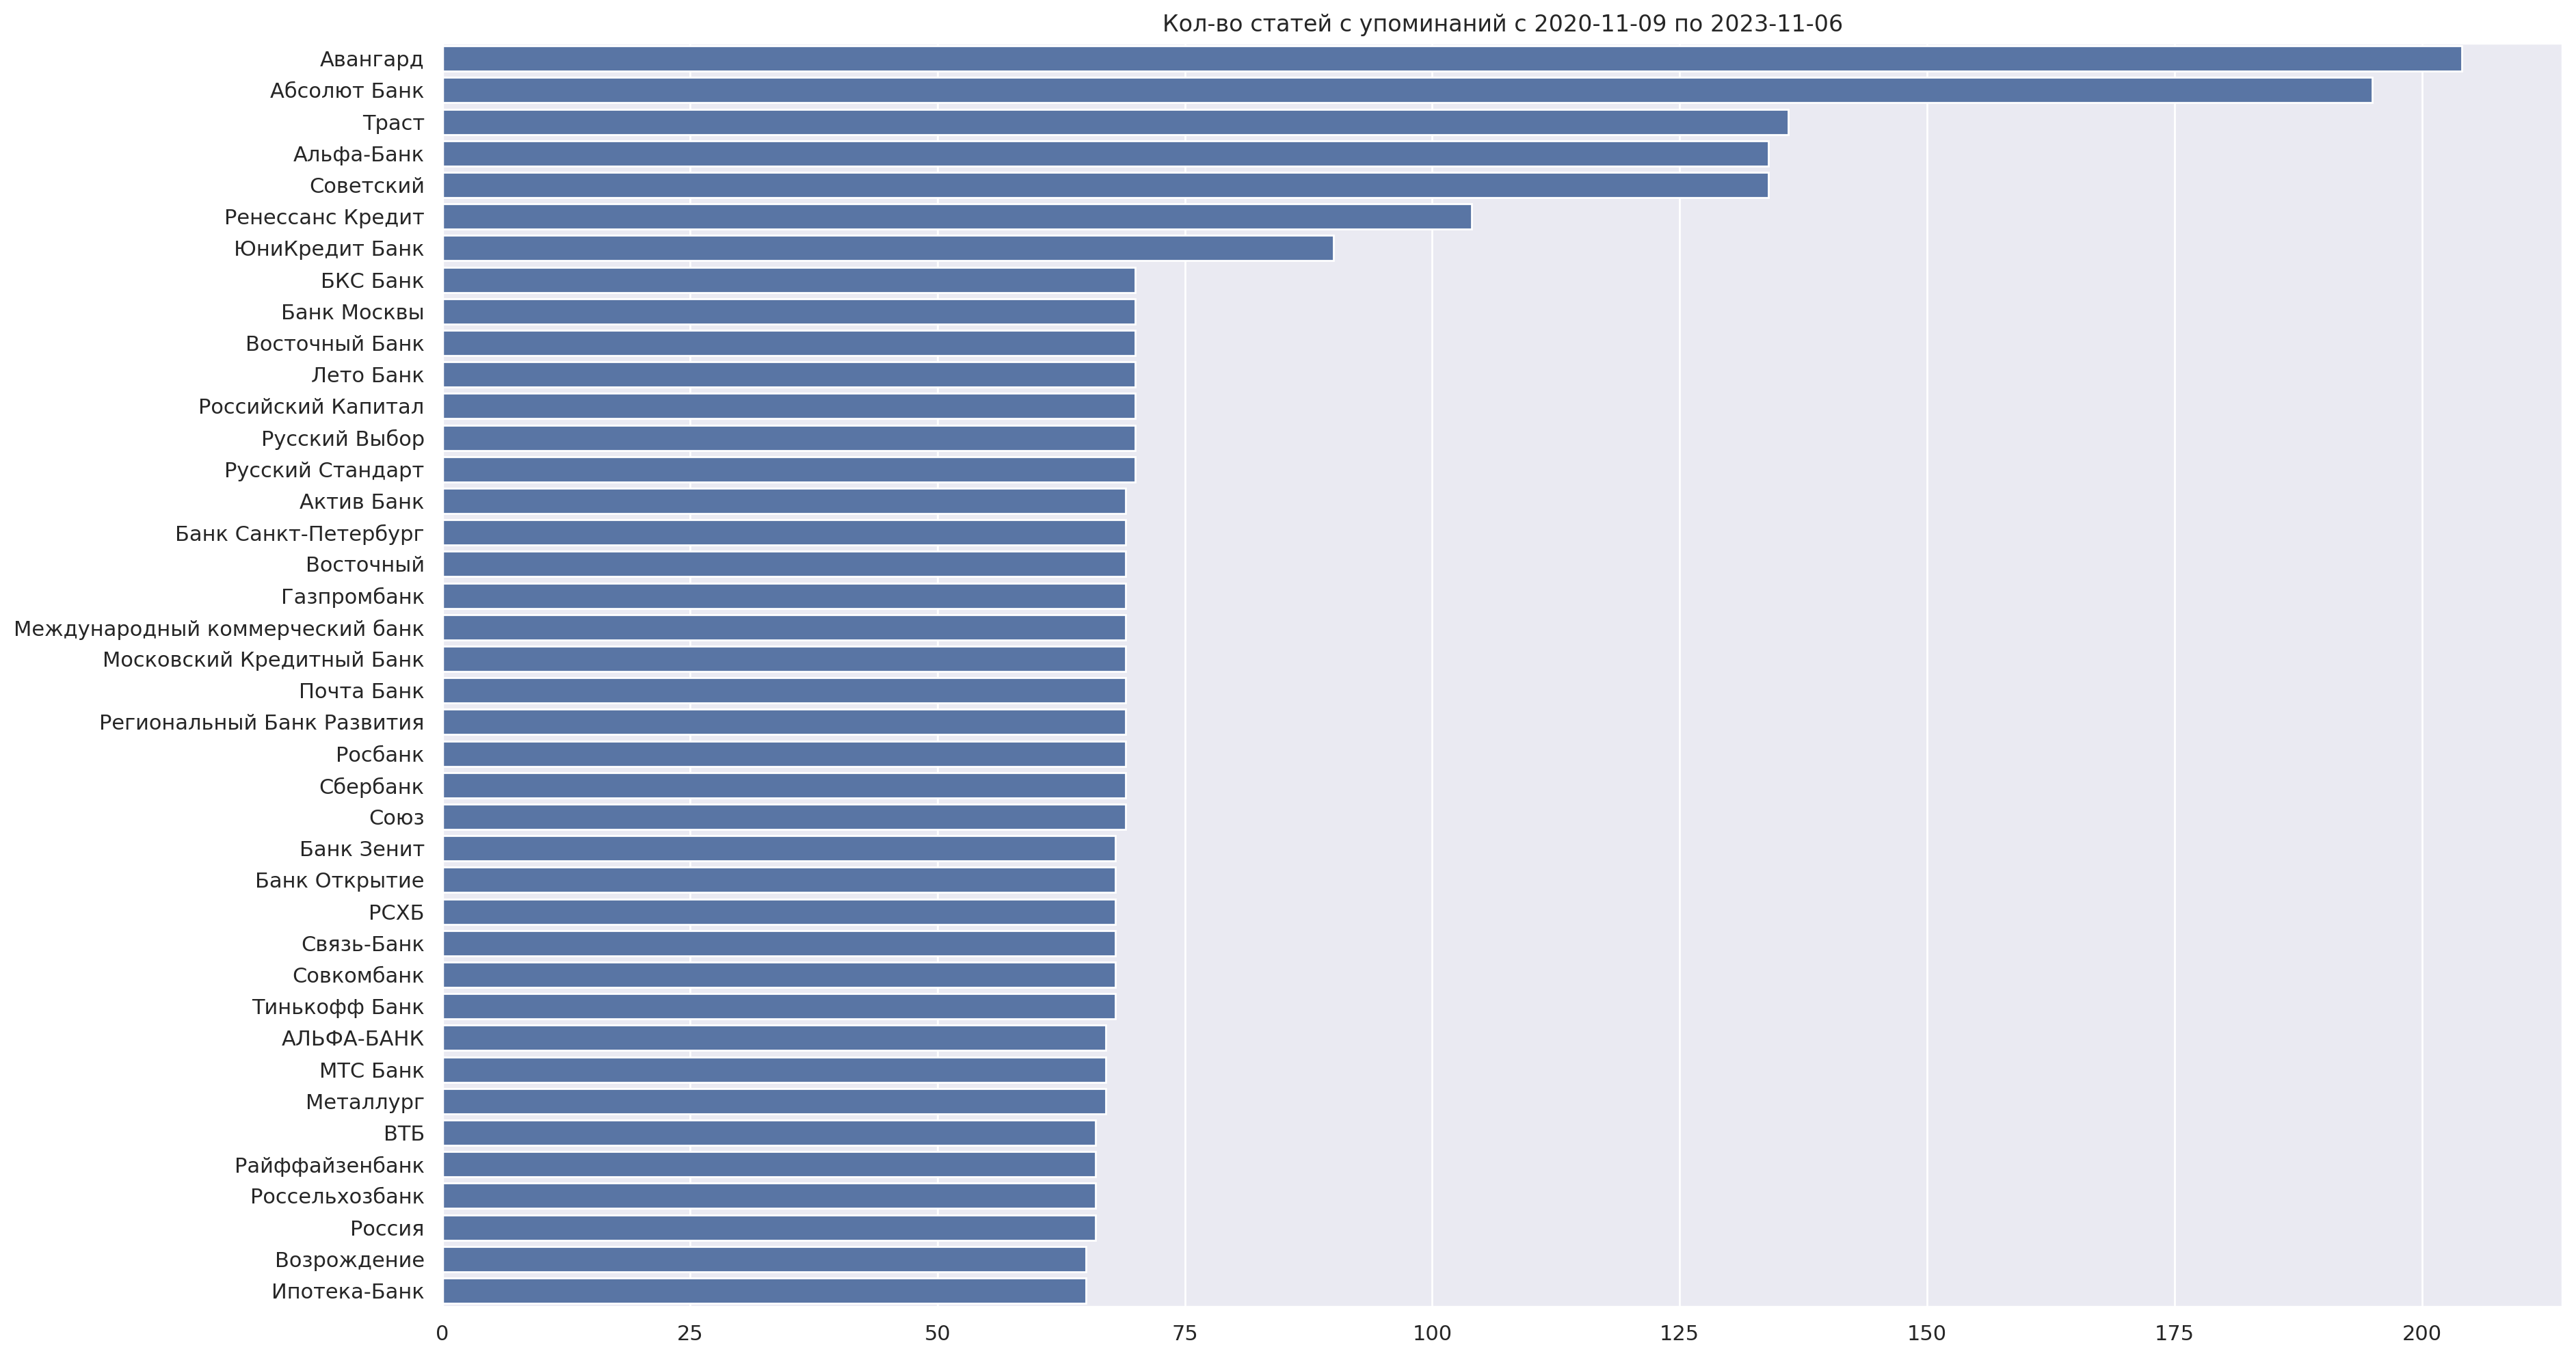

In [ ]:
names = [x[0] for x in bank_set_]
counts = [x[1] for x in bank_set_]

sns.barplot(x=counts, y=names).set_title(f'Кол-во статей с упоминаний c {min_} по {max_}')

In [ ]:
from wordcloud import WordCloud

In [ ]:
def draw_cloud(data):
    wc = WordCloud(background_color='white', max_words=1000,
                   width=1000, height=500)
    texts = data.astype(str)
    joint_text = ' '.join(list(texts))
    wc.generate(joint_text)
    return wc.to_image()

### Обработка текстов

In [ ]:
data = comments_raw_data[comments_raw_data['bank'].isin(names)][['bank', 'paper_text']]

In [ ]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation


mystem = Mystem()
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)
    return text

In [ ]:
pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 839.0 kB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=b7d9061e971c0fe28e2e557148091567cc66977a3e36ffa6e81ac348507fe6f2
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
data['paper_text'] = data['paper_text'].parallel_apply(lambda x: preprocess_text(str(x)))

In [ ]:
data

,bank,paper_text
0,Сбербанк,крупный российский разработчик базовый станция...
1,Сбербанк,планироваться законодательно возлагать нотариу...
2,Сбербанк,чистый процентный маржа сбербанк впервые неско...
3,Сбербанк,подконтрольный adg group компания строить мест...
4,Сбербанк,банка пока сдержанно реагировать повышение клю...
...,...,...
4142,Актив Банк,альфа-банк намерен подавать заявление признани...
4143,Актив Банк,банк россия опубликовывать оценка состояние те...
4144,Актив Банк,"становиться известно “ ъ ”, российский банк ..."
4145,Актив Банк,"становиться известно “ ъ ”, гсу скр москва о..."


### Получение embeddings

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=3)
tfidf.fit(data['paper_text'])

In [ ]:
bank_vectors = pd.DataFrame(columns=[x for x in range(len(tfidf.vocabulary_))])
for bank in tqdm(np.unique(data['bank'])):
    sen = np.mean(tfidf.transform(data[data['bank'] == bank]['paper_text']), axis=0)
    vec = pd.DataFrame(sen)
    bank_vectors =  pd.concat([bank_vectors, vec], axis=0)

In [ ]:
bank_vectors = bank_vectors.to_numpy()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(bank_vectors)

In [ ]:
clusster_data = pd.DataFrame({'bank':np.unique(data['bank'])})

In [ ]:
clusster_data['kmeans_clusters'] = kmeans.labels_

In [ ]:
clusster_data[clusster_data['kmeans_clusters'] == 0]

In [ ]:
clusster_data[clusster_data['kmeans_clusters'] == 1]

In [ ]:
clusster_data[clusster_data['kmeans_clusters'] == 2]

In [ ]:
data = data.merge(clusster_data, how='left', on='bank')

In [ ]:
draw_cloud(data[data['kmeans_clusters'] == 1]['paper_text'])

In [ ]:
draw_cloud(data[data['kmeans_clusters'] == 0]['paper_text'])

In [ ]:
draw_cloud(data[data['kmeans_clusters'] == 2]['paper_text'])

### Embeddings

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [ ]:
def embed_bert_cls(text, model=model, tokenizer=tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [ ]:
data

,bank,paper_text
0,Сбербанк,крупный российский разработчик базовый станция...
1,Сбербанк,планироваться законодательно возлагать нотариу...
2,Сбербанк,чистый процентный маржа сбербанк впервые неско...
3,Сбербанк,подконтрольный adg group компания строить мест...
4,Сбербанк,банка пока сдержанно реагировать повышение клю...
...,...,...
4142,Актив Банк,альфа-банк намерен подавать заявление признани...
4143,Актив Банк,банк россия опубликовывать оценка состояние те...
4144,Актив Банк,"становиться известно “ ъ ”, российский банк ..."
4145,Актив Банк,"становиться известно “ ъ ”, гсу скр москва о..."


In [ ]:
bank_vectors = pd.DataFrame(columns=[x for x in range(312)])
for bank in tqdm(np.unique(data['bank'])):
    bank_embeds = pd.DataFrame(columns=[x for x in range(312)])
    bank_text_data = data[data['bank'] == bank]['paper_text']
    for text in bank_text_data:
        bank_embeds = pd.concat([bank_embeds, pd.DataFrame(embed_bert_cls(text).reshape(1,-1))], axis=0)
    sen = np.mean(bank_embeds.to_numpy(), axis=0)
    vec = pd.DataFrame(sen.reshape(1,-1))
    bank_vectors =  pd.concat([bank_vectors, vec], axis=0)

100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(bank_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [ ]:
clusster_data = pd.DataFrame({'bank':np.unique(data['bank'])})
clusster_data['bert_clusters'] = kmeans.labels_

In [ ]:
clusster_data[clusster_data['bert_clusters'] == 0]

,bank,bert_clusters
3,Актив Банк,0
7,Банк Москвы,0
8,Банк Открытие,0
9,Банк Санкт-Петербург,0
10,ВТБ,0
13,Восточный Банк,0
16,Лето Банк,0
17,МТС Банк,0
18,Международный коммерческий банк,0
19,Металлург,0


In [ ]:
clusster_data[clusster_data['bert_clusters'] == 1]

,bank,bert_clusters
2,Авангард,1
11,Возрождение,1
12,Восточный,1
29,Россия,1
30,Русский Выбор,1
31,Русский Стандарт,1
34,Советский,1
36,Союз,1


In [ ]:
clusster_data[clusster_data['bert_clusters'] == 2]

,bank,bert_clusters
0,АЛЬФА-БАНК,2
1,Абсолют Банк,2
4,Альфа-Банк,2
5,БКС Банк,2
6,Банк Зенит,2
14,Газпромбанк,2
15,Ипотека-Банк,2
20,Московский Кредитный Банк,2
22,РСХБ,2
23,Райффайзенбанк,2


In [ ]:
data = data.merge(clusster_data, how='left', on='bank')

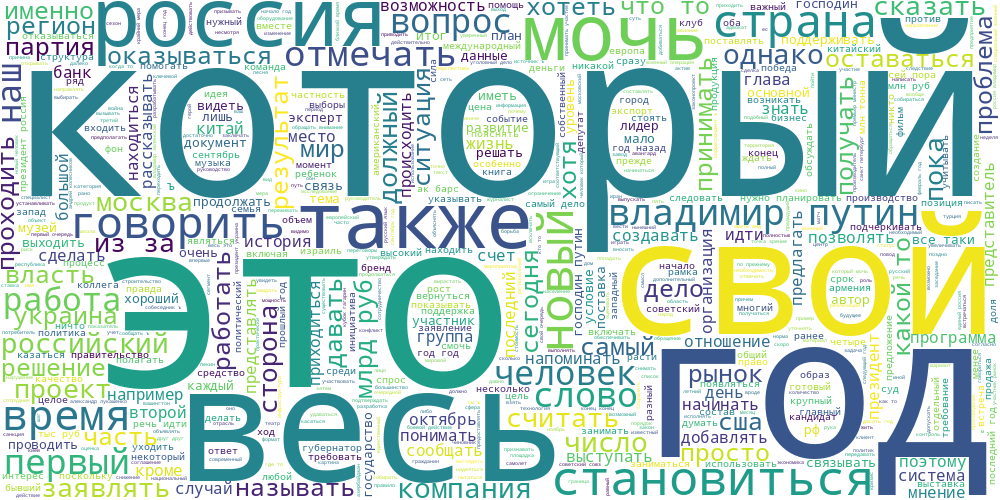

In [ ]:
draw_cloud(data[data['bert_clusters'] == 1]['paper_text'])

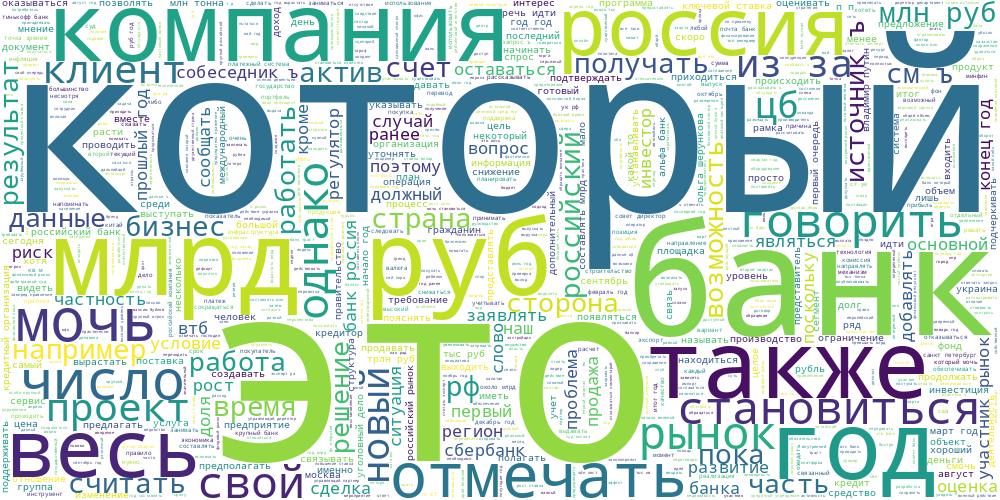

In [ ]:
draw_cloud(data[data['bert_clusters'] == 0]['paper_text'])

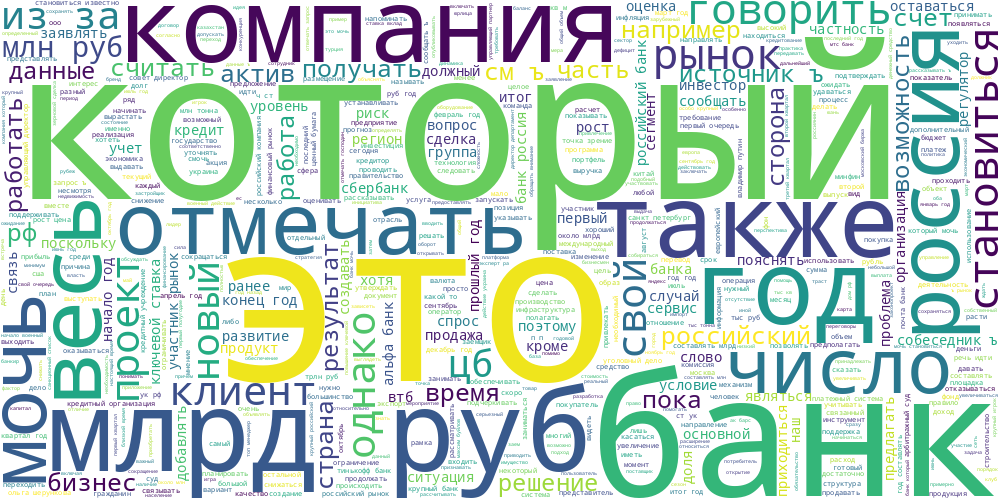

In [ ]:
draw_cloud(data[data['bert_clusters'] == 0]['paper_text'])